In [1]:
import Dynamics
from casadi import *
from IPython.display import HTML
import Environment

### hyperparameters

In [2]:
T = 0.4 # MPC horizon
N = 8 # horion divides on N steps

# boundary conditions
U_MAX = 20 
U_MIN = - U_MAX



### Creation of integrator
$
\dot{
\begin{pmatrix}
     {\phi} \\
     {\phi}
\end{pmatrix}} = 
\begin{pmatrix}
     {\dot{\phi}} \\
     {rhs}
\end{pmatrix}
$

In [3]:
x = vertcat(Dynamics.phi,Dynamics.dphi)
u = Dynamics.u

ode = Dynamics.my_rhs(x[:3],x[3:],u)
dae = {'x':x, 'p':u, 'ode':ode}
intg_options = {'tf': T/N}

intg = integrator('intg','rk',dae,intg_options)

### Problem dimention

In [4]:
x_dim = 6
u_dim = 1

### MPC formulation

#### initialization

In [5]:
opti = casadi.Opti()
x = opti.variable(x_dim*(N+1)) # all state history shape x_dim*(N+1)
u = opti.variable(u_dim *N) # u history
x0 = opti.parameter(x_dim) # initial x0 state
xgoal = opti.parameter(x_dim*(N+1)) # goal state

# opti.parameter is const, we will set up it latter
# opti.variable will be variated by casadi methods

#### constraints and conditions

In [6]:
weights = [0,1,1,0,0,0] # ТУУУУУТ ВЕСА ВЕСА ТУУУУУУУТ

dx = x - xgoal # error
weighted_sum = dx.T @ np.diag(weights * (N+1)) @dx 

opti.minimize(weighted_sum) # try minimize error

opti.subject_to(x[0:x_dim] == x0)
for k in range(1,N+1):
    opti.subject_to(x[k*x_dim : (k+1)*x_dim] == \
                    intg(x0 = x[(k-1)*x_dim : k*x_dim],p = u[(k-1)*u_dim : k*u_dim])['xf'])

for i in range(N):
        opti.subject_to(opti.bounded(U_MIN,u[i*u_dim],U_MAX))

#### constract solver from "opti" settings

In [7]:
opti_options = {'print_in':False, 'print_out':False, 'print_time':False}
solver_options = {'print_level' : 0}

opti.solver('ipopt',opti_options,solver_options)
mpc = opti.to_function("MPC",[x0,xgoal],[u],["x0","xgoal"],["u_opt"])
mpc

Function(MPC:(x0[6],xgoal[54])->(u_opt[8]) MXFunction)

###  Environment testing

In [8]:
env = Environment.DoublePendulumEnv([0,3.14/2,3.14/2,0,0,0],dt = T/N ) # initialise system
x_calc_goal = np.array([0,np.pi/2,np.pi/2,0,0,0]*(N+1),dtype = float) # state_goal

Environment initialized


#### loop
* x = env.state
* u = mpc(x,goal)  - give optimal u variable with shape u_dim * N
* env.step(u[0]) - apply first action


In [9]:
env.reset()
x0_calc = env.state
NumSteps = 150

X_story = [0]*NumSteps
X_story[0] = x0_calc
X_real = [0]*NumSteps
X_real[0] = x0_calc
U_hist = []

for i in range(1,NumSteps):
    u = mpc(env.state,x_calc_goal).full()
    u = u[0]
    U_hist.append(u)
    env.step(u)
    
    x0_calc = intg(x0 = x0_calc,p = u)['xf'].full() # it is integrator from mpc for testing consistency of predictions between env and mpc
    X_real[i] = env.state
    X_story[i] = np.array(x0_calc)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



### Visual

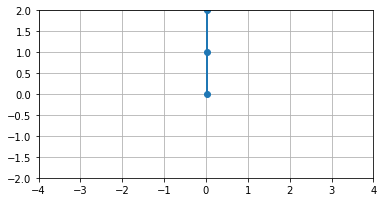

In [10]:
ani = env.render()
HTML(ani.to_jshtml())

In [11]:
env.state_history[0]

array([0.  , 1.57, 1.57, 0.  , 0.  , 0.  ])

In [12]:
x_calc_goal

array([0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 1.57079633, 0.        ,
       0.        , 0.        , 0.        , 1.57079633, 1.57079633,
       0.        , 0.        , 0.        , 0.        , 1.57079633,
       1.57079633, 0.        , 0.        , 0.        , 0.        ,
       1.57079633, 1.57079633, 0.        , 0.        , 0.        ,
       0.        , 1.57079633, 1.57079633, 0.        , 0.        ,
       0.        , 0.        , 1.57079633, 1.57079633, 0.        ,
       0.        , 0.        , 0.        , 1.57079633, 1.57079633,
       0.        , 0.        , 0.        , 0.        , 1.57079633,
       1.57079633, 0.        , 0.        , 0.        ])

In [13]:
U_hist

[array([-0.38719667]),
 array([1.03185597]),
 array([-0.96425561]),
 array([1.01229439]),
 array([-0.97067119]),
 array([0.99568907]),
 array([-0.97232166]),
 array([0.98200184]),
 array([-0.97063897]),
 array([0.97064379]),
 array([-0.9665913]),
 array([0.961012]),
 array([-0.96090413]),
 array([0.95256014]),
 array([-0.95417391]),
 array([0.94490657]),
 array([-0.9468943]),
 array([0.93778313]),
 array([-0.93938031]),
 array([0.93098787]),
 array([-0.93183547]),
 array([0.92438635]),
 array([-0.92438184]),
 array([0.91789551]),
 array([-0.9170846]),
 array([0.91146898]),
 array([-0.90997118]),
 array([0.90508497]),
 array([-0.90304568]),
 array([0.89873706]),
 array([-0.8962991]),
 array([0.8924275]),
 array([-0.88971625]),
 array([0.88616273]),
 array([-0.88328015]),
 array([0.87995049]),
 array([-0.87697455]),
 array([0.87379814]),
 array([-0.87078523]),
 array([0.86771188]),
 array([-0.86470046]),
 array([0.86169635]),
 array([-0.85871097]),
 array([0.8557547]),
 array([-0.8528096

In [14]:
dx @ np.array([[10,10],[10,10]])

RuntimeError: .../casadi/core/sparsity.cpp:412: Assertion "x.size2()==y.size1()" failed:
Matrix product with incompatible dimensions. Lhs is 54x1 and rhs is 2x2.